# **MobileNetV3small and BCE Loss for Lumen Classification Task** [Feedback]

## This Note Book:

*   Augmentation,
*   Hyperparameter Optimization,
*   BCE,
*   Evaluation Hard Examples

---
**Author:** Fatemeh Shariftabar

**Affiliation:** Sharif University of technology

**Date:** September, 2025

---
**Task:** Lumen Binary Classification Task

**Task Definition:**
The goal of this project is binary classification of colonoscopy images into two categories:

*   haslumen – images containing visible lumen
*   nolumen – images without a clearly visible lumen

**Model:** MobileNetV3

**Loss function:** BCE

# Set Up and Configurations

In [ ]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [ ]:
!pip install -U ray[data,train,tune,serve]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 132.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.5/201.5 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.2/452.2 kB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.8/510.8 kB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 122.7 MB/s eta 0:00:00


In [ ]:
SAVE_DIR = "/content/drive/MyDrive/iMIAP_Project_lifesky"

In [ ]:
DATA_DIR = "/content/split_dataset"

In [ ]:
raytune_name = "mobilenet_hpo_ray_acc_bce"
model_save_name = "mobnetv3s_best_param_acc_bce.pth"
model_save_path = os.path.join(SAVE_DIR, model_save_name)

# 1. Load Splited Dataset
---
Images are categorized into two folders: `haslumen` and `nolumen`.

**We have a balanced dataset:**

* Lumen: 5,469 images (~51.8%)
* No Lumen: 5,090 images (~48.2%)
* Total: 10,559 images


**Train/Validation/Test split:**

*   10% -> Test set
*   10% -> Validation set
*   80% -> Train set

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/iMIAP_Project_lifesky/split_dataset.zip" -d "/content/split_dataset"

Streaming output truncated to the last 5000 lines.
  inflating: /content/split_dataset/train/nolumen/chinese_case_72_f_0121_positive.jpg  
  inflating: /content/split_dataset/train/nolumen/case_M_20181109094641_0U62372110931241_1_007_001-1_Negative_ayy_image006081.jpg  
  inflating: /content/split_dataset/train/nolumen/case_M_20181228140523_0U62365122821823_1_001_001-1_a3_ayy_image0137.jpg  
  inflating: /content/split_dataset/train/nolumen/case_M_20181109094641_0U62372110931241_1_007_001-1_Negative_ayy_image000039.jpg  
  inflating: /content/split_dataset/train/nolumen/case_M_20181015101337_0U62363101576536_1_005_002-1_a23_ayy_image0019.jpg  
  inflating: /content/split_dataset/train/nolumen/case_M_20181024134247_0U62368102492146_1_002_001-1_Negative_ayy_image000252.jpg  
  inflating: /content/split_dataset/train/nolumen/chinese_case_26_f_0071_positive.jpg  
  inflating: /content/split_dataset/train/nolumen/case_M_20190112093830_0U62372011292129_1_001_001-1_a10_ayy_image0037.jpg  
  i

### DATASET and TRANSFORMATIONS

In [ ]:
# ==========================================
# DATASET and TRANSFORMATIONS
# ==========================================
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# --- Transformations ---
IMG_SIZE = 224

train_transforms = transforms.Compose([
    # --- Geometric Transformations ---
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.85, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),     # Left-right flips are realistic
    transforms.RandomVerticalFlip(p=0.2),       # Less common, but possible due to scope rotation
    transforms.RandomRotation(degrees=15),      # ±15° for natural camera tilt

    transforms.RandomAffine(
        degrees=0,
        translate=(0.05, 0.05),  # Simulates slight camera movement
        scale=(0.9, 1.1),        # Small zoom in/out
        shear=5                  # Small shear for realism
    ),

    # --- Photometric Augmentations ---
    transforms.ColorJitter(
        brightness=0.25,   # Lighting changes in colon
        contrast=0.25,
        saturation=0.2,    # Keep subtle to preserve tissue realism
        hue=0.05           # Small hue shifts only
    ),
    transforms.ToTensor(),
    # --- Noise & Blur for Motion Simulation ---
    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.2)),  # motion/focus blur
    ], p=0.3),

    transforms.RandomApply([
        transforms.Lambda(lambda x: x + 0.03 * torch.randn_like(x))  # realistic camera noise
    ], p=0.2),

    # --- Final Normalization ---

    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


val_test_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Load datasets
train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "val"), transform=val_test_transforms)
test_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "test"), transform=val_test_transforms)

print(f"🔍 Detected classes: {train_dataset.class_to_idx}")
print("Train size:", len(train_dataset))
print("Validation size:", len(val_dataset))
print("Test size:", len(test_dataset))

🔍 Detected classes: {'haslumen': 0, 'nolumen': 1}
Train size: 8447
Validation size: 1056
Test size: 1056


### Visualization: Train augmentation samples

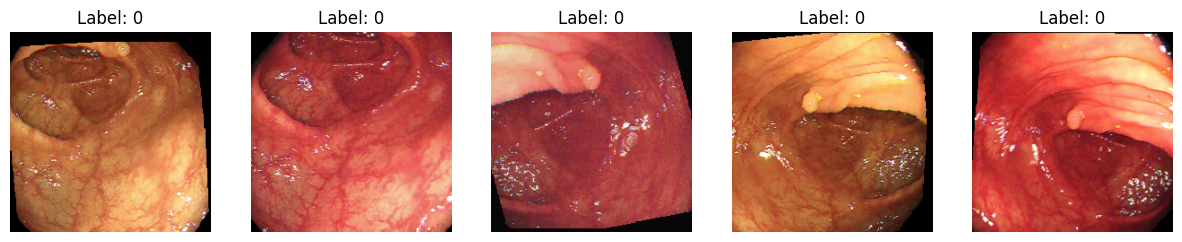

In [ ]:
import matplotlib.pyplot as plt

def denormalize_image(tensor, mean, std):
    """Reverse normalization for display."""
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return tensor * std + mean  # reverse the normalization

def show_augmented_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 10))
    for i in range(num_images):
        image, label = dataset[i]
        # Make sure the tensor is on CPU and detached
        img = image.cpu().detach()

        # Denormalize
        img = denormalize_image(img, mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])

        # Clip values to [0, 1] for safe display
        img = torch.clamp(img, 0, 1)

        # Convert to HWC format for matplotlib
        img = img.permute(1, 2, 0)
        axes[i].imshow(img.numpy())
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")
    plt.show()

show_augmented_images(train_dataset, num_images=5)


# 2. Hyperparameter optimization: RayTune
     Metric for find the best params : validation_accuracy

In [ ]:
try:
    ray.shutdown()
    print("✅ Shutdown any existing Ray instance.")
except Exception as e:
    print(f"ℹ️ No Ray instance to shutdown: {e}")

### Running the Optimization with Ray Tune

In [ ]:
import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.air import session

# -----------------------------------------------------------
# 2. The Trainable Function for Ray Tune
# -----------------------------------------------------------

def trainable_function(config):
    # Retrieve hyperparameters from the config dictionary
    lr = config["lr"]
    batch_size = config["batch_size"]
    optimizer_name = config["optimizer"]
    weight_decay = config["weight_decay"]

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
    num_ftrs = model.classifier[3].in_features
    model.classifier[3] = nn.Linear(num_ftrs, 1) # Single output for binary classification
    model.to(device)

    if optimizer_name == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        momentum = config.get("momentum", 0.9) # Use .get() for optional parameters
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

    criterion = nn.BCEWithLogitsLoss()
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    # --- Training Loop ---
    for epoch in range(10):
        model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.float().unsqueeze(1).to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        # Evaluation phase
        model.eval()
        val_loss_sum = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.float().unsqueeze(1).to(device)
                output = model(data)
                val_loss_sum += criterion(output, target).item() * data.size(0)
                probabilities = torch.sigmoid(output)
                predictions = (probabilities > 0.5).long()
                total += data.size(0)
                correct += (predictions == target.long()).sum().item()

        val_loss = val_loss_sum / total
        val_accuracy = correct / total

        session.report({"val_accuracy": val_accuracy, "val_loss": val_loss})

# -----------------------------------------------------------
# 3. Running the Optimization with Ray Tune
# -----------------------------------------------------------

ray.init(num_cpus=8, num_gpus=1)

# Define the search space
search_space = {
    "lr": tune.loguniform(1e-5, 1e-3),
    "batch_size": tune.choice([16, 32, 64]),
    "optimizer": tune.choice(["AdamW", "SGD"]),
    "weight_decay": tune.loguniform(1e-6, 1e-2),
    "momentum": tune.uniform(0.8, 0.99)
}

# Configure the ASHA scheduler for early stopping (pruning)
scheduler = ASHAScheduler(
    metric="val_accuracy",
    mode="max",
    max_t = 10, # The maximum number of epochs (training_iteration)
    grace_period=1, # Don't prune trials until they've run for at least 1 epoch
    reduction_factor=2
)

tuner = tune.Tuner(
    tune.with_resources(
        trainable_function,
        resources={"cpu": 2, "gpu": 0.5 if torch.cuda.is_available() else 0}
    ),
    param_space=search_space,
    tune_config=tune.TuneConfig(
        scheduler=scheduler,
        num_samples=50, # Number of different hyperparameter combos to try
    ),
    # This will save checkpoints in case of disconnection
    run_config=ray.air.RunConfig(
        stop={"training_iteration": 10},
        name= raytune_name,
        storage_path=SAVE_DIR
    )
)

results = tuner.fit()

# Get the best trial based on your chosen metric
best_result = results.get_best_result(metric="val_accuracy", mode="max")

print("\n--- Ray Tune Optimization Finished ---")
print(f"Best trial found: {best_result.path}")
print(f"Best validation accuracy: {best_result.metrics['val_accuracy']:.4f}")
print("Best hyperparameters: ")
for key, value in best_result.config.items():
    print(f"  {key}: {value}")

2025-09-07 16:51:46,622	INFO worker.py:1942 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


+----------------------------------------------------------+
| Configuration for experiment     mobilenet_hpo_ray_new   |
+----------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator   |
| Scheduler                        AsyncHyperBandScheduler |
| Number of trials                 50                      |
+----------------------------------------------------------+

View detailed results here: /content/drive/MyDrive/iMIAP_Project_lifesky/mobilenet_hpo_ray_new
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2025-09-07_16-51-39_433072_648/artifacts/2025-09-07_16-51-52/mobilenet_hpo_ray_new/driver_artifacts`

Trial status: 50 PENDING
Current time: 2025-09-07 16:51:53. Total running time: 1s
Logical resource usage: 4.0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------------------------------------------------+
| Trial 

  0%|          | 0.00/9.83M [00:00<?, ?B/s]
100%|██████████| 9.83M/9.83M [00:00<00:00, 179MB/s]
100%|██████████| 9.83M/9.83M [00:00<00:00, 120MB/s]


Streaming output truncated to the last 5000 lines.
| trainable_function_f41d9_00005   RUNNING      3.85123e-05             64   AdamW            0.000278694     0.907696        1            88.5041         0.863636     0.316961 |
| trainable_function_f41d9_00000   TERMINATED   2.0389e-05              32   SGD              7.42884e-05     0.906294       10           894.303          0.806818     0.451051 |
| trainable_function_f41d9_00001   TERMINATED   0.000126682             32   AdamW            2.35509e-05     0.827714       10           894.429          0.941288     0.145599 |
| trainable_function_f41d9_00003   TERMINATED   3.94634e-05             16   SGD              1.2793e-05      0.987892        1            91.4516         0.830492     0.350905 |
| trainable_function_f41d9_00004   TERMINATED   7.58819e-05             32   SGD              4.02854e-06     0.964973        1            91.7525         0.82197      0.439375 |
| trainable_function_f41d9_00006   PENDING      0.0003

2025-09-07 18:52:37,279	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/content/drive/MyDrive/iMIAP_Project_lifesky/mobilenet_hpo_ray_new' in 1.2210s.



Trial status: 50 TERMINATED
Current time: 2025-09-07 18:52:37. Total running time: 2hr 0min 44s
Logical resource usage: 2.0/8 CPUs, 0.5/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                       status                lr     batch_size   optimizer       weight_decay     momentum     iter     total time (s)     val_accuracy     val_loss |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| trainable_function_f41d9_00000   TERMINATED   2.0389e-05              32   SGD              7.42884e-05     0.906294       10           894.303          0.806818     0.451051 |
| trainable_function_f41d9_00001   TERMINATED   0.000126682             32   AdamW            2.35509e-05     

In [ ]:
# Get the best trial based on your chosen metric
best_result_acc = results.get_best_result(metric="val_accuracy", mode="max")
print(f"Best trial found: {best_result_acc.path}")
print(f"Best validation accuracy: {best_result_acc.metrics['val_accuracy']:.4f}")
print(f"Best validation loss: {best_result_acc.metrics['val_loss']:.4f}")
print("Best hyperparameters: ")
for key, value in best_result_acc.config.items():
    print(f"  {key}: {value}")

Best trial found: /content/drive/MyDrive/iMIAP_Project_lifesky/mobilenet_hpo_ray_new/trainable_function_f41d9_00015_15_batch_size=16,lr=0.0003,momentum=0.9750,optimizer=AdamW,weight_decay=0.0001_2025-09-07_16-51-53
Best validation accuracy: 0.9527
Best validation loss: 0.1335
Best hyperparameters: 
  lr: 0.00029966072262418487
  batch_size: 16
  optimizer: AdamW
  weight_decay: 5.160087862958095e-05
  momentum: 0.974996007915337


In [ ]:
# Get the best trial based on your chosen metric
best_result_loss = results.get_best_result(metric="val_loss", mode="min")
print(f"Best trial found: {best_result_loss.path}")
print(f"Best validation accuracy: {best_result_loss.metrics['val_accuracy']:.4f}")
print(f"Best validation loss: {best_result_loss.metrics['val_loss']:.4f}")
print("Best hyperparameters: ")
for key, value in best_result_loss.config.items():
    print(f"  {key}: {value}")

Best trial found: /content/drive/MyDrive/iMIAP_Project_lifesky/mobilenet_hpo_ray_new/trainable_function_f41d9_00015_15_batch_size=16,lr=0.0003,momentum=0.9750,optimizer=AdamW,weight_decay=0.0001_2025-09-07_16-51-53
Best validation accuracy: 0.9527
Best validation loss: 0.1335
Best hyperparameters: 
  lr: 0.00029966072262418487
  batch_size: 16
  optimizer: AdamW
  weight_decay: 5.160087862958095e-05
  momentum: 0.974996007915337


# 3. Train the model with best hyperparameters

*   **Model:** MobileNet V3 small
*   **Weights:** Pretrained
*   **Loss Function:**  bce
*   **Optimizer:**
    -  Learning rate scheduling using ReduceLROnPlateau
    -  Early stopping based on validation loss

      **Best hyperparameters:**

          * Best validation accuracy: 0.9527
          * lr: 0.00029966072262418487
          * weight_decay: 5.160087862958095e-05
          * batch_size: 16
          * optimizer: adamw


### Load best config from ray tune

In [ ]:
import os
from ray import tune
from ray.tune.result_grid import ResultGrid

# Construct the full path to the experiment directory
experiment_path = os.path.join(SAVE_DIR, raytune_name)

try:
    restored_tuner = tune.Tuner.restore(path=experiment_path, trainable="trainable_function")

    # Get the ResultGrid which contains all the trial results
    results: ResultGrid = restored_tuner.get_results()

    # Get the best result based on the metric and mode used for the scheduler
    best_result = results.get_best_result(metric="val_accuracy", mode="max")

    if best_result:
        print("\n--- Loaded Best Result ---")
        print(f"Best trial found: {best_result.path}")
        print(f"Best validation accuracy: {best_result.metrics['val_accuracy']:.4f}")
        print("Best hyperparameters:")
        for key, value in best_result.config.items():
            print(f"  {key}: {value}")
    else:
        print("No successful trials found in the experiment.")

except FileNotFoundError:
    print(f"Error: Experiment directory not found at {experiment_path}")
    print("Please check that your SAVE_DIR and experiment name are correct.")
except Exception as e:
    print(f"An error occurred while loading the experiment: {e}")


--- Loaded Best Result ---
Best trial found: /content/drive/MyDrive/iMIAP_Project_lifesky/mobilenet_hpo_ray_new/trainable_function_f41d9_00015_15_batch_size=16,lr=0.0003,momentum=0.9750,optimizer=AdamW,weight_decay=0.0001_2025-09-07_16-51-53
Best validation accuracy: 0.9527
Best hyperparameters:
  lr: 0.00029966072262418487
  batch_size: 16
  optimizer: AdamW
  weight_decay: 5.160087862958095e-05
  momentum: 0.974996007915337


### Retrain & Save the final model

In [ ]:
# ==========================================
# RETRAIN & SAVE THE FINAL MODEL
# ==========================================
from torch.optim.lr_scheduler import ReduceLROnPlateau
best_config = best_result.config

# Re-create loaders with the best batch size
train_loader = DataLoader(train_dataset, batch_size=best_config['batch_size'], shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=best_config['batch_size'], shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=best_config['batch_size'], shuffle=False, num_workers=4)

# Instantiate a new model and optimizer with the best parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
num_ftrs = model.classifier[3].in_features
model.classifier[3] = nn.Linear(num_ftrs, 1) # Single output for binary classification
model.to(device)

criterion = nn.BCEWithLogitsLoss()


# Use the best optimizer and learning rate from the hparams dictionary
if best_config['optimizer'] == "AdamW":
    optimizer = optim.AdamW(
        [
            {'params': model.features.parameters(), 'lr': best_config['lr'] * 0.1},
            {'params': model.classifier.parameters(), 'lr': best_config['lr']}
        ],
        weight_decay=best_config['weight_decay']
    )
else: # SGD
    optimizer = optim.SGD(
        [
            {'params': model.features.parameters(), 'lr': best_config['lr'] * 0.1},
            {'params': model.classifier.parameters(), 'lr': best_config['lr']}
        ],
        momentum=best_config['momentum'],
        weight_decay=best_config['weight_decay']
    )

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# --- Training ---
EPOCHS = 50
PATIENCE = 5
best_val_loss = float('inf')
patience_counter = 0
best_model_wts = None

train_losses, train_accuracies , val_losses, val_accuracies = [], [], [],[]

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).float().unsqueeze(1)  # Convert to float

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)
    # --- Validation ---
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader.dataset)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"\n📊 Epoch [{epoch+1}/{EPOCHS}]")
    print(f"Train Loss: {epoch_loss:.4f} | Train Acc: {train_accuracy:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")
    print(f"📉 Current LR: {optimizer.param_groups[0]['lr']}")

    scheduler.step(val_loss)

# --- Early Stopping ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = model.state_dict()
        patience_counter = 0
        print("✅ Validation loss improved. Model saved.")
    else:
        patience_counter += 1
        print(f"⚠️ No improvement. Patience {patience_counter}/{PATIENCE}")
        if patience_counter >= PATIENCE:
            print("⏹️ Early stopping triggered.")
            break

# --- Save Best Model ---
if best_model_wts is not None:
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), model_save_path)
    print(f"\n📦 Best model saved to: {model_save_path}")


📊 Epoch [1/50]
Train Loss: 0.3847 | Train Acc: 82.36% | Val Loss: 0.2536 | Val Acc: 89.02%
📉 Current LR: 2.996607226241849e-05
✅ Validation loss improved. Model saved.

📊 Epoch [2/50]
Train Loss: 0.3165 | Train Acc: 85.86% | Val Loss: 0.2371 | Val Acc: 90.15%
📉 Current LR: 2.996607226241849e-05
✅ Validation loss improved. Model saved.

📊 Epoch [3/50]
Train Loss: 0.2945 | Train Acc: 87.36% | Val Loss: 0.1970 | Val Acc: 92.42%
📉 Current LR: 2.996607226241849e-05
✅ Validation loss improved. Model saved.

📊 Epoch [4/50]
Train Loss: 0.2794 | Train Acc: 87.47% | Val Loss: 0.1899 | Val Acc: 93.28%
📉 Current LR: 2.996607226241849e-05
✅ Validation loss improved. Model saved.

📊 Epoch [5/50]
Train Loss: 0.2562 | Train Acc: 89.23% | Val Loss: 0.1856 | Val Acc: 92.42%
📉 Current LR: 2.996607226241849e-05
✅ Validation loss improved. Model saved.

📊 Epoch [6/50]
Train Loss: 0.2564 | Train Acc: 89.05% | Val Loss: 0.1776 | Val Acc: 92.99%
📉 Current LR: 2.996607226241849e-05
✅ Validation loss improved.

### Training/Validation Loss and Accuracy

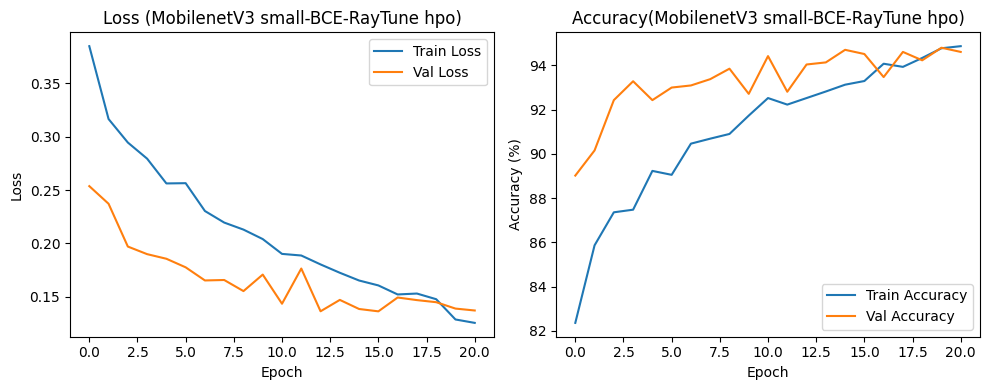

In [ ]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss (MobilenetV3 small-BCE-RayTune hpo)")
plt.legend()

# Plot Accuracy
plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy(MobilenetV3 small-BCE-RayTune hpo)")
plt.legend()
plt.tight_layout()
plt.show()

# 4. Testing Phase

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=best_config['batch_size'], shuffle=False, num_workers=4)
class_names = test_dataset.classes
print(f"🔍 Detected classes: {test_dataset.class_to_idx}")

try:
    # Check if the file exists before trying to load
    if torch.cuda.is_available():
        # Load the state dictionary to the GPU if available
        model.load_state_dict(torch.load(model_save_path))
    else:
        # Load the state dictionary to the CPU
        model.load_state_dict(torch.load(model_save_path, map_location=torch.device('cpu')))
    print("✅ Model loaded successfully!")

except FileNotFoundError:
    print(f"❌ Error: Model file not found at '{model_save_path}'. Please check the path.")
except Exception as e:
    print(f"❌ An error occurred during model loading: {e}")

✅ Model loaded successfully!


## Confusion Matrix and Report Metrics


📊 Classification Report on Test set:
              precision    recall  f1-score   support

    haslumen       0.93      0.95      0.94       547
     nolumen       0.95      0.93      0.94       509

    accuracy                           0.94      1056
   macro avg       0.94      0.94      0.94      1056
weighted avg       0.94      0.94      0.94      1056



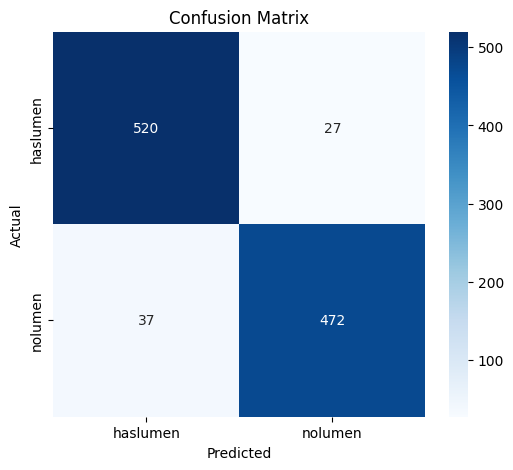

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        outputs = model(inputs)
        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds).astype(int).flatten()
all_labels = np.array(all_labels).astype(int).flatten()

# Classification Report
print("\n📊 Classification Report on Test set:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Test Samples
We visualize sample predictions from the test set:

*  🟢 Green text: correct prediction
*  🔴 Red text: incorrect prediction

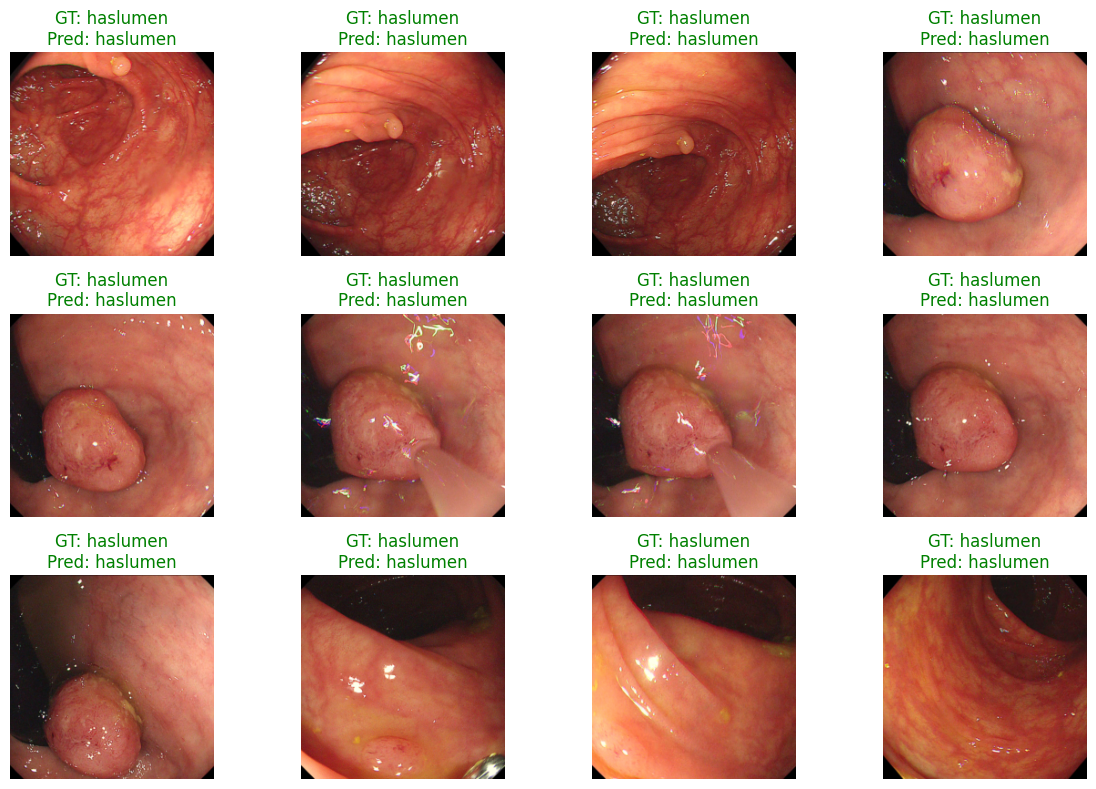

In [ ]:
model.eval()
shown = 0
plt.figure(figsize=(12, 8))

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        logits = model(imgs)
        probs = torch.sigmoid(logits).cpu().squeeze()
        preds = (probs > 0.5).int()

        for i in range(len(imgs)):
            if shown >= 12: break  # Display 12 samples

            img_np = imgs[i].cpu().permute(1, 2, 0).numpy()
            img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Denormalize
            img_np = img_np.clip(0, 1)

            true_label = class_names[int(labels[i])]
            pred_label = class_names[int(preds[i])]
            color = 'green' if true_label == pred_label else 'red'

            plt.subplot(3, 4, shown + 1)
            plt.imshow(img_np)
            plt.title(f"GT: {true_label}\nPred: {pred_label}", color=color)
            plt.axis('off')

            shown += 1
        if shown >= 12: break

plt.tight_layout()
plt.show()

## Testing Robustness (Test with noisy inputs)

**We tested the model under image perturbations (data augmentations not seen during training), such as:**
*   Rotation
*   Brightness change
*   Blur

Outputs:
*  🟢 Green text: correct prediction
*  🔴 Red text: incorrect prediction

**Observations**:

*  The model correctly classifies most variants.
*  Some errors occur when strong glare or blur is introduced.
*  Model shows moderate robustness to common perturbations.

In [ ]:
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import torch
from PIL import Image
import numpy as np
import random
def predict(image_tensor):
    model.eval()
    with torch.no_grad():
        out = model(image_tensor)
        pred = torch.sigmoid(out) if isinstance(criterion, nn.BCEWithLogitsLoss) else torch.softmax(out, dim=1)
        return pred.cpu().numpy()

def plot_images_grid(images, title_colors ,titles=None, n_cols=3,figsize=(12, 6) ):
    n_images = len(images)
    n_rows = (n_images + n_cols - 1) // n_cols

    plt.figure(figsize=figsize)
    for idx, img in enumerate(images):

        img = img.squeeze().cpu()
        img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
        img = img.clamp(0,1).permute(1,2,0).numpy()


        plt.subplot(n_rows, n_cols, idx + 1)
        plt.imshow(img)
        plt.axis('off')
        if titles is not None:
            plt.title(titles[idx],color=title_colors[idx])
    plt.tight_layout()
    plt.show()

# Test some images from test set
for i in [0,10,25,50,80]:
    print(f"Testing Robustness of image {i+1} from Test set")
    img, label = test_dataset[i]
    img = img.unsqueeze(0).to(device)

    transforms_list = [
        ("Original", img),
        ("Rotated +15°", TF.rotate(img, angle=15)),
        ("Horizontal Flip", TF.hflip(img)),
        ("Vertical Flip", TF.vflip(img)),
        ("Brightness", TF.adjust_brightness(img, 0.95)),
        ("Blurred", TF.gaussian_blur(img, kernel_size=5,sigma=random.uniform(0.1, 1.2)))
    ]

    Title_Colors = []
    Images = []
    Titles = []

    for name, transformed_img in transforms_list:
        pred = predict(transformed_img)
        pred_label = np.argmax(pred) if pred.shape[1] > 1 else (pred > 0.5).astype(int)
        class_name = class_names[int(pred_label)]

        true_label = class_names[int(label)]
        color = 'green' if true_label == class_name else 'red'

        img_title = f"{name} \nGT: {true_label} \nPred: {class_name}"

        Images.append(transformed_img)
        Titles.append(img_title)
        Title_Colors.append(color)


    plot_images_grid(Images,Title_Colors, Titles,n_cols=3)


Output hidden; open in https://colab.research.google.com to view.

## Grad-CAM Visualization
**To understand the model’s focus areas dTo understand the model’s focus areas during prediction, we used Grad-CAM:**

*  Correct predictions: attention aligned with lumen or mucosal structures
*  Incorrect predictions: attention often distracted by artifacts (e.g., glare)

Output:
*  🟢 Green text: correct prediction
*  🔴 Red text: incorrect prediction

**Observation:** Misclassifications often relate to poor lighting or ambiguity in lumen visibility. This insight can inform future preprocessing improvements (e.g., glare reduction, contrast normalization).

In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 25.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=f75b817c346ef94f5c6ba1562da35de649f3a02bd6246570e5f361895c0a8364
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Select the target convolutional layer for MobileNetV3 Small
target_layer = model.features[-1]  # Last Conv layer before classifier

# Hook variables
gradients = None
activations = None

def save_gradient(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0]

def save_activation(module, input, output):
    global activations
    activations = output

# Register hooks
handle_activ = target_layer.register_forward_hook(save_activation)
handle_grad = target_layer.register_backward_hook(save_gradient)

def generate_gradcam(input_tensor, model, target_class=None):
    model.eval()

    input_tensor = input_tensor.to(device)
    input_tensor.requires_grad = True

    output = model(input_tensor)

    # Apply sigmoid for BCEWithLogitsLoss
    probs = torch.sigmoid(output)

    if target_class is None:
        pred_class = (probs > 0.5).int().item()
    else:
        pred_class = target_class

    # Create scalar output for backward()
    class_score = probs[0][0] if pred_class == 0 else probs[0][1] if probs.shape[1] > 1 else probs[0]

    model.zero_grad()
    class_score.backward()

    # Global Average Pooling on gradients
    pooled_grads = torch.mean(gradients, dim=[0, 2, 3])  # shape: [C]

    # Weight activations
    cam = torch.zeros(activations.shape[2:], dtype=torch.float32).to(device)
    for i in range(len(pooled_grads)):
        cam += pooled_grads[i] * activations[0, i, :, :]

    cam = torch.relu(cam)
    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-8)
    cam = cam.detach().cpu().numpy()

    return cam, pred_class


def show_gradcam_on_image(img_tensor, cam,true_label, pred_label,color, alpha=0.5):
    img = img_tensor.squeeze().cpu()
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    img = img + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    img = img.clamp(0, 1).permute(1, 2, 0).detach().cpu().numpy()

    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    overlay = heatmap * alpha + img
    overlay = np.clip(overlay, 0, 1)  # Ensure valid range

    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Original Image \nGT: {true_label}",color=color)

    plt.subplot(1,3,2)
    plt.imshow(heatmap)
    plt.axis('off')
    plt.title(f"Heatmap \nPred: {pred_label}",color=color)

    plt.subplot(1,3,3)
    plt.imshow(overlay)
    plt.axis('off')
    plt.title(f"GradCam Overlay  \nPred: {pred_label}",color=color)
    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


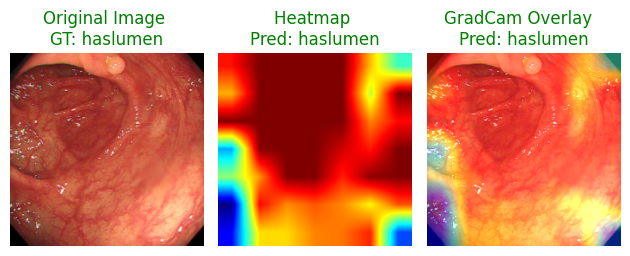

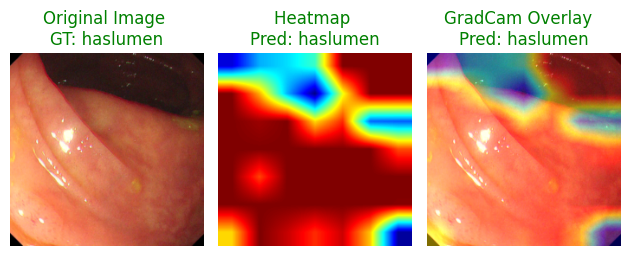

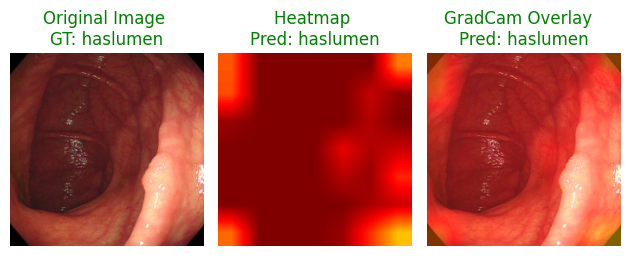

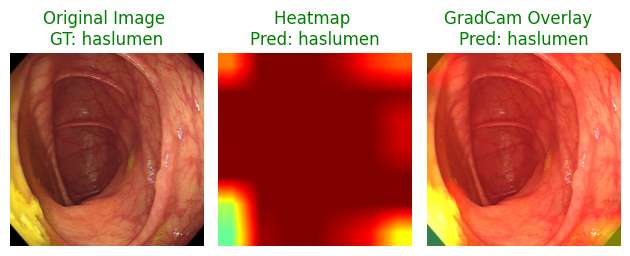

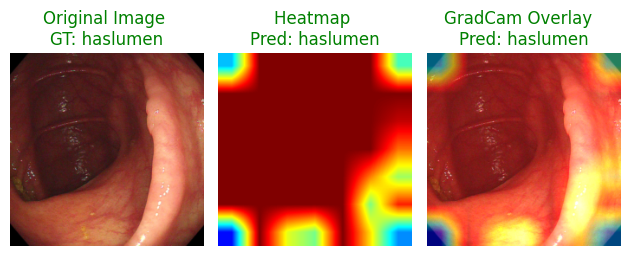

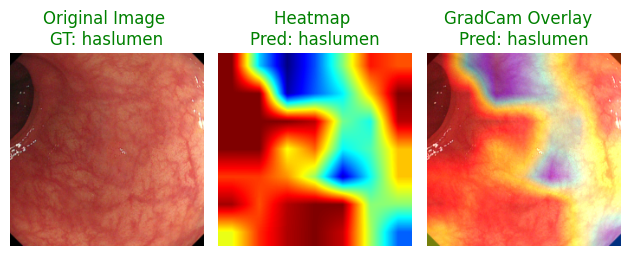

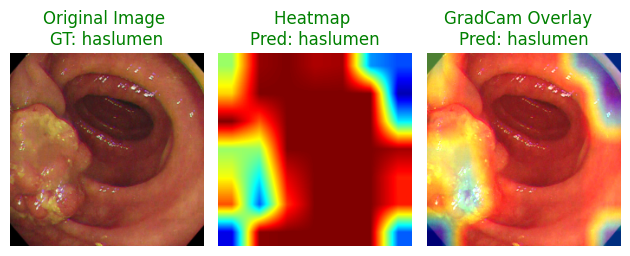

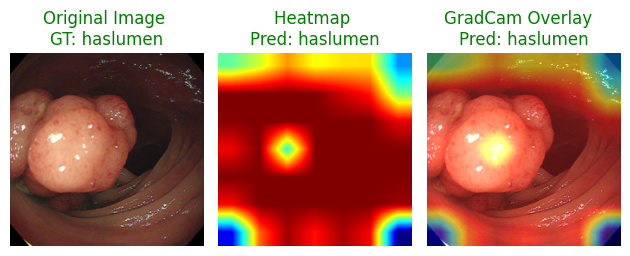

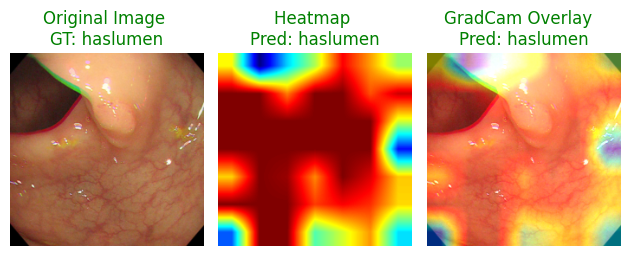

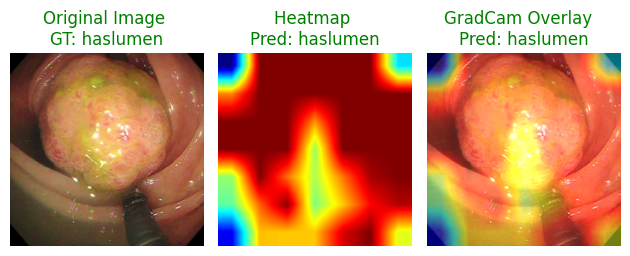

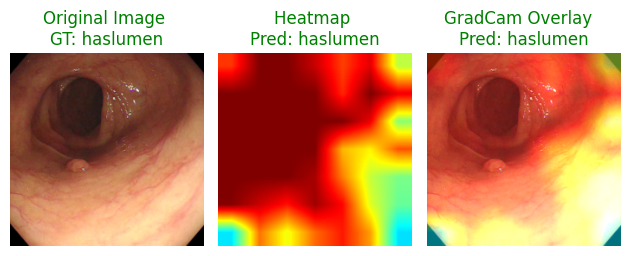

In [ ]:
num_imgs = np.arange(0, 101, 10)
for i in num_imgs:
    img_tensor, label = test_dataset[i]  # Get one image from test set
    img_tensor = img_tensor.unsqueeze(0).to(device)  # Add batch dimension

    cam, pred = generate_gradcam(img_tensor, model) #pred is 0 or 1
    true_label = class_names[label]
    pred_label = class_names[pred]
    color = 'green' if true_label == pred_label else 'red'

    show_gradcam_on_image(img_tensor, cam, true_label, pred_label,color)

# 5. HEM

## Set up and Configurations

### load dataset

In [ ]:
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from torchvision.datasets import ImageFolder

class ImageFolderWithPaths(ImageFolder):
    def __getitem__(self, index):
        img, label = super().__getitem__(index)
        path = self.imgs[index][0]
        return img, label, path

# Load datasets
train_set = ImageFolderWithPaths(os.path.join(DATA_DIR, "train"), transform=train_transforms)
val_set = ImageFolderWithPaths(os.path.join(DATA_DIR, "val"), transform=val_test_transforms)
test_set = ImageFolderWithPaths(os.path.join(DATA_DIR, "test"), transform=val_test_transforms)

train_loader = DataLoader(train_set, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False, num_workers=4)
class_names = test_set.classes
print(f"🔍 Detected classes: {test_dataset.class_to_idx}")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
num_ftrs = model.classifier[3].in_features
model.classifier[3] = nn.Linear(num_ftrs, 1) # Single output for binary classification
model.load_state_dict(torch.load(model_save_path))
model.to(device)

🔍 Detected classes: {'haslumen': 0, 'nolumen': 1}


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

### Functions for Finding Hard Examples

In [ ]:
import math
from matplotlib.backends.backend_pdf import PdfPages

def analyze_hard_examples(model, dataloader, device, class_names=['haslumen', 'nolumen']):
    """
    Comprehensive analysis of hard examples after training
    """
    model.eval()

    all_paths = []
    all_images = []
    all_true_labels = []
    all_preds = []
    all_probs = []
    all_losses = []

    with torch.no_grad():
        for images, labels, paths in dataloader:  # Modify if your dataloader doesn't return paths
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            probs = torch.sigmoid(outputs).squeeze()
            preds = (probs > 0.5).long()

            # Calculate loss per sample
            loss_fn = nn.BCEWithLogitsLoss(reduction='none')
            losses = loss_fn(outputs.squeeze(), labels.float())

            all_paths.extend(paths)
            all_images.extend(images.cpu())
            all_true_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_losses.extend(losses.cpu().numpy())

    # Convert to numpy arrays
    true_labels = np.array(all_true_labels)
    preds = np.array(all_preds)
    probs = np.array(all_probs)
    losses = np.array(all_losses)

    return {
        'paths': all_paths,
        'images': all_images,
        'true_labels': true_labels,
        'preds': preds,
        'probs': probs,
        'losses': losses
    }

def identify_hard_examples(analysis_results, confidence_threshold=0.3):
    """
    Identify different types of hard examples
    """
    true_labels = analysis_results['true_labels']
    preds = analysis_results['preds']
    probs = analysis_results['probs']
    paths = analysis_results['paths']
    losses = analysis_results['losses']

    # 1. Misclassified examples
    misclassified_mask = (preds != true_labels)
    misclassified_indices = np.where(misclassified_mask)[0]

    # 2. Low confidence correct predictions
    correct_mask = (preds == true_labels)
    confidence = np.where(preds == 1, probs, 1 - probs)  # Confidence for predicted class
    low_confidence_mask = (correct_mask) & (confidence < 0.7)  # Correct but unsure

    # 3. High confidence incorrect predictions (most dangerous)
    high_confidence_incorrect_mask = (misclassified_mask) & (confidence > 0.8)

    # 4. Borderline cases (confidence near 0.5)
    borderline_mask = (np.abs(confidence - 0.5) < confidence_threshold)

    hard_examples = {
        'misclassified': {
            'indices': misclassified_indices,
            'paths': [paths[i] for i in misclassified_indices],
            'true_labels': true_labels[misclassified_indices],
            'pred_labels': preds[misclassified_indices],
            'confidences': confidence[misclassified_indices],
            'losses': losses[misclassified_indices]
        },
        'low_confidence_correct': {
            'indices': np.where(low_confidence_mask)[0],
            'paths': [paths[i] for i in np.where(low_confidence_mask)[0]],
            'confidences': confidence[low_confidence_mask]
        },
        'high_confidence_incorrect': {
            'indices': np.where(high_confidence_incorrect_mask)[0],
            'paths': [paths[i] for i in np.where(high_confidence_incorrect_mask)[0]],
            'confidences': confidence[high_confidence_incorrect_mask]
        },
        'borderline': {
            'indices': np.where(borderline_mask)[0],
            'paths': [paths[i] for i in np.where(borderline_mask)[0]],
            'confidences': confidence[borderline_mask]
        }
    }

    return hard_examples

def show_misclassified_grid(hard_examples,hard_type, analysis_results, class_names, max_examples=36):
    """
    Show misclassified examples in a grid (limited to max_examples)
    """
    images = analysis_results['images']
    true_labels = analysis_results['true_labels']
    preds = analysis_results['preds']
    probs = analysis_results['probs']

    misclassified_indices = hard_examples[hard_type]['indices']

    if len(misclassified_indices) == 0:
        print(f"No {hard_type} examples found!")
        return

    # Limit to max_examples
    display_indices = misclassified_indices[:min(max_examples, len(misclassified_indices))]

    n_cols = 6
    n_rows = math.ceil(len(display_indices) / n_cols)

    plt.figure(figsize=(20, 3 * n_rows))
    plt.suptitle(f'{hard_type} Examples ({len(display_indices)} shown, total: {len(misclassified_indices)})', fontsize=16)

    for i, idx in enumerate(display_indices):
        plt.subplot(n_rows, n_cols, i + 1)

        # Denormalize image
        img = images[idx].permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())

        # Get prediction info
        true_label = class_names[int(true_labels[idx])]
        pred_label = class_names[int(preds[idx])]
        confidence = probs[idx] if preds[idx] == 1 else 1 - probs[idx]

        plt.imshow(img)
        if hard_type =='low_confidence_correct':
          plt.title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.3f}',
                  color='green', fontsize=8)
        else:
          plt.title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.3f}',
                  color='red', fontsize=8)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    if len(misclassified_indices) > max_examples:
        print(f"Showing {max_examples} out of {len(misclassified_indices)} {hard_type} examples")


def save_misclassified_to_pdf(hard_examples, analysis_results, class_names, filename='misclassified_examples.pdf'):
    """
    Save all misclassified examples to a PDF file
    """
    images = analysis_results['images']
    true_labels = analysis_results['true_labels']
    preds = analysis_results['preds']
    probs = analysis_results['probs']

    misclassified_indices = hard_examples['misclassified']['indices']

    if len(misclassified_indices) == 0:
        print("No misclassified examples found!")
        return

    with PdfPages(filename) as pdf:
        examples_per_page = 9
        n_pages = math.ceil(len(misclassified_indices) / examples_per_page)

        for page in range(n_pages):
            start_idx = page * examples_per_page
            end_idx = min((page + 1) * examples_per_page, len(misclassified_indices))
            current_indices = misclassified_indices[start_idx:end_idx]

            fig = plt.figure(figsize=(15, 15))
            n_cols = 3
            n_rows = math.ceil(len(current_indices) / n_cols)

            for i, idx in enumerate(current_indices):
                ax = plt.subplot(n_rows, n_cols, i + 1)

                # Denormalize image
                img = images[idx].permute(1, 2, 0).numpy()
                img = (img - img.min()) / (img.max() - img.min())

                # Get prediction info
                true_label = class_names[int(true_labels[idx])]
                pred_label = class_names[int(preds[idx])]
                confidence = probs[idx] if preds[idx] == 1 else 1 - probs[idx]

                ax.imshow(img)
                ax.set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.3f}',
                           color='red', fontsize=9)
                ax.axis('off')

            plt.suptitle(f'Misclassified Examples - Page {page + 1}/{n_pages}', fontsize=16)
            plt.tight_layout()
            pdf.savefig(fig)
            plt.close(fig)

    print(f"Saved {len(misclassified_indices)} misclassified examples to {filename}")


## Hard Example Mining: Post-Training Analysis [Test - dataset]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Analyze model predictions on test set
analysis_results = analyze_hard_examples(model, test_loader, device, class_names)
hard_examples = identify_hard_examples(analysis_results, confidence_threshold=0.3)

# Print summary
print(f"Misclassified count: {len(hard_examples['misclassified']['indices'])}")
print(f"Low confidence correct count: {len(hard_examples['low_confidence_correct']['indices'])}")
print(f"High confidence incorrect count: {len(hard_examples['high_confidence_incorrect']['indices'])}")
print(f"Borderline count: {len(hard_examples['borderline']['indices'])}")

Misclassified count: 64
Low confidence correct count: 31
High confidence incorrect count: 33
Borderline count: 88


### Visualization

In [ ]:
# Visualiz Hard Examples : 'high_confidence_incorrect'
show_misclassified_grid(hard_examples, 'high_confidence_incorrect', analysis_results, class_names, max_examples=36)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Visualiz Hard Examples : 'low_confidence_correct'
show_misclassified_grid(hard_examples, 'low_confidence_correct', analysis_results, class_names, max_examples=36)

Output hidden; open in https://colab.research.google.com to view.

### Save missclassified samples

In [ ]:
save_misclassified_to_pdf(hard_examples, analysis_results, class_names, 'bce_all_misclassified_testset.pdf')

Saved 64 misclassified examples to bce_all_misclassified_testset.pdf


## Hard Example Mining: Post-Training Analysis [Val - dataset]

In [ ]:
import numpy as np
# Step 1: Analyze model predictions on test set
analysis_results = analyze_hard_examples(model, val_loader, device, class_names)
hard_examples = identify_hard_examples(analysis_results, confidence_threshold=0.3)

# Print summary
print(f"Misclassified count: {len(hard_examples['misclassified']['indices'])}")
print(f"Low confidence correct count: {len(hard_examples['low_confidence_correct']['indices'])}")
print(f"High confidence incorrect count: {len(hard_examples['high_confidence_incorrect']['indices'])}")
print(f"Borderline count: {len(hard_examples['borderline']['indices'])}")

Misclassified count: 57
Low confidence correct count: 27
High confidence incorrect count: 28
Borderline count: 79


### Visualization

In [ ]:
# Visualiz Hard Examples : 'high_confidence_incorrect'
show_misclassified_grid(hard_examples, 'high_confidence_incorrect', analysis_results, class_names, max_examples=36)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Visualiz Hard Examples : 'low_confidence_correct'
show_misclassified_grid(hard_examples, 'low_confidence_correct', analysis_results, class_names, max_examples=36)

Output hidden; open in https://colab.research.google.com to view.